In [1]:
import numpy as np
import pandas as pd
import os
import random
import torch
from PAES.configs import PAESConfig
from models.AES import FeatureModel
from dvrl.predictor_model import MLP
from transformers import AutoConfig
from utils.create_embedding_feautres import create_embedding_features, normalize_scores
from utils.dvrl_utils import remove_top_p_sample, fit_func, pred_func, calc_qwk, random_remove_sample, get_dev_sample
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from utils.read_data import get_readability_features, get_linguistic_features, get_features_by_id, scale_features, get_normalized_features
from utils.general_utils import get_min_max_scores

/Users/takumishibata/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
test_prompt_id = 8
# output_path = f'outputs/DVRL_DomainAdaptation/'
# output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}/'
# output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}_devsize0.01/'
# output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}_devsize30/'
output_path = f'outputs/DVRL_DomainAdaptation_FeatureModel{test_prompt_id}_devsize40/'

seed = 12
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
attribute_name = 'score'

# Load data
data_path = 'data/cross_prompt_attributes/' + str(test_prompt_id) + '/'
model_name = 'microsoft/deberta-v3-large'

cpu


load data from data/cross_prompt_attributes/8/...
Loading embedding from cache...
Selected 40 samples.
Selected sample indices: [667, 53, 39, 632, 140, 70, 497, 163, 709, 428, 317, 664, 719, 596, 249, 157, 561, 573, 309, 694, 515, 397, 488, 352, 278, 198, 259, 439, 671, 519, 102, 252, 64, 353, 580, 683, 600, 105, 592, 571]
X_source:  (12253, 86)
Y_source:  (12253,)
Y_source max:  1.0
Y_source min:  0.0
X_dev:  (40, 86)
Y_dev:  (40,)
Y_dev max:  0.8333333333333334
Y_dev min:  0.16666666666666666
X_target:  (683, 86)
Y_target:  (683,)
Y_target max:  1.0
Y_target min:  0.3333333333333333
QWK: 0.4071
dev QWK: 0.6993
QWK: 0.4071
dev QWK: 0.6993
QWK: 0.4071
dev QWK: 0.6993
QWK: 0.3469
dev QWK: 0.6858
QWK: 0.4206
dev QWK: 0.7427
QWK: 0.4032
dev QWK: 0.6930
QWK: 0.3223
dev QWK: 0.6668
QWK: 0.4437
dev QWK: 0.7762
QWK: 0.3956
dev QWK: 0.6945
QWK: 0.2973
dev QWK: 0.6500
QWK: 0.4514
dev QWK: 0.7882
QWK: 0.3911
dev QWK: 0.6863
QWK: 0.2749
dev QWK: 0.6340
QWK: 0.4438
dev QWK: 0.7838
QWK: 0.3800
dev 

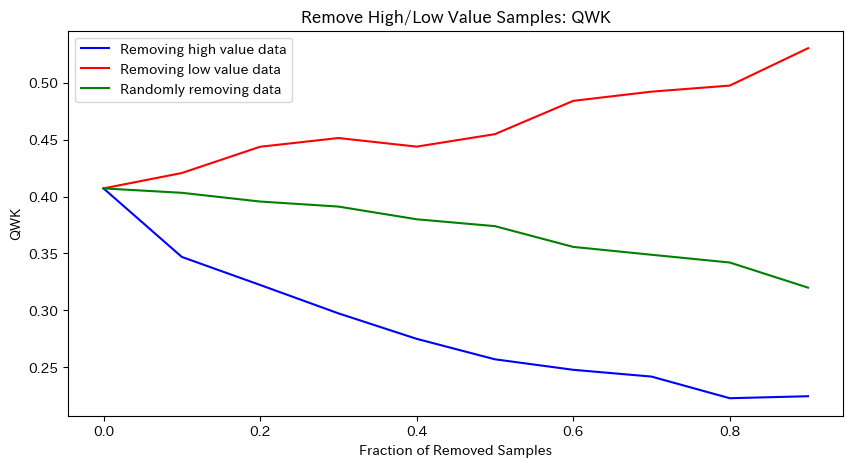

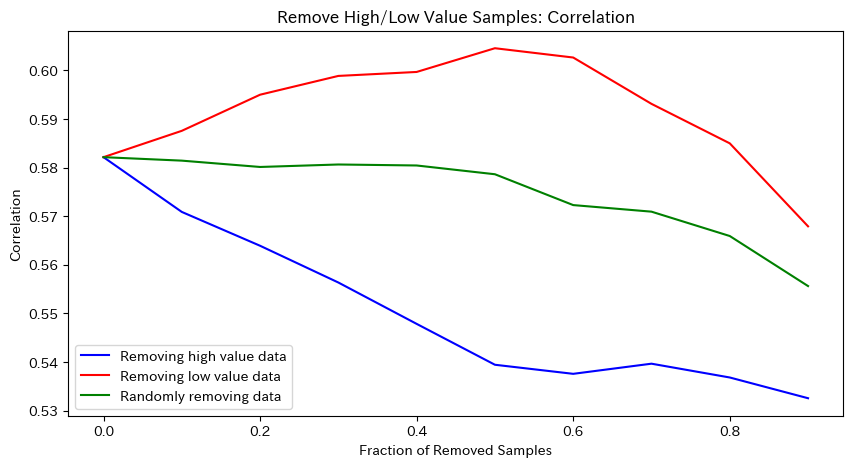

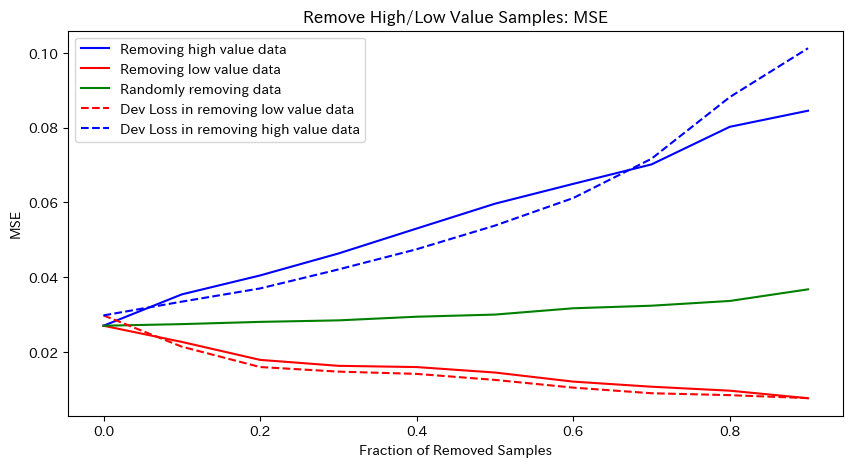

In [17]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def train_and_evaluate(x_source, y_source, x_dev, y_dev, x_test, y_test, test_prompt_id, weights, model_name, device):
    pred_model = FeatureModel(35, 51).to(device)

    history = fit_func(pred_model, x_source, y_source, batch_size=512, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, x_test, batch_size=256, device=device)
    y_dev_pred = pred_func(pred_model, x_dev, batch_size=256, device=device)
    qwk = calc_qwk(y_test, y_pred, test_prompt_id, 'score')
    corr = np.corrcoef(y_test, np.array(y_pred).flatten())[0, 1]
    mse = mean_squared_error(y_test, y_pred)
    dev_mse = mean_squared_error(y_dev, y_dev_pred)
    dev_qwk = calc_qwk(y_dev, y_dev_pred, test_prompt_id, 'score')
    print(f'QWK: {qwk:.4f}')
    print(f'dev QWK: {dev_qwk:.4f}')

    return qwk, corr, mse, dev_mse

def plot_results(p, high_qwks, low_qwks, random_qwks, high_corr, low_corr, random_corr, high_mse, low_mse, random_mse, high_loss, low_loss, output_path):
    plt.figure(figsize=(10, 5))
    plt.plot(p, high_qwks, label='Removing high value data', color='blue')
    plt.plot(p, low_qwks, label='Removing low value data', color='red')
    plt.plot(p, random_qwks, label='Randomly removing data', color='green')
    plt.title('Remove High/Low Value Samples: QWK')
    plt.xlabel('Fraction of Removed Samples')
    plt.ylabel('QWK')
    plt.legend()
    plt.savefig(output_path + 'remove_high_low_samples_qwk.png')

    plt.figure(figsize=(10, 5))
    plt.plot(p, high_corr, label='Removing high value data', color='blue')
    plt.plot(p, low_corr, label='Removing low value data', color='red')
    plt.plot(p, random_corr, label='Randomly removing data', color='green')
    plt.title('Remove High/Low Value Samples: Correlation')
    plt.xlabel('Fraction of Removed Samples')
    plt.ylabel('Correlation')
    plt.legend()
    plt.savefig(output_path + 'remove_high_low_samples_corr.png')

    plt.figure(figsize=(10, 5))
    plt.plot(p, high_mse, label='Removing high value data', color='blue')
    plt.plot(p, low_mse, label='Removing low value data', color='red')
    plt.plot(p, random_mse, label='Randomly removing data', color='green')
    plt.plot(p, low_loss, label='Dev Loss in removing low value data', color='red', linestyle='dashed')
    plt.plot(p, high_loss, label='Dev Loss in removing high value data', color='blue', linestyle='dashed')
    plt.title('Remove High/Low Value Samples: MSE')
    plt.xlabel('Fraction of Removed Samples')
    plt.ylabel('MSE')
    plt.legend()
    plt.savefig(output_path + 'remove_high_low_samples_mse.png')

set_seed(seed)
# Load data

train_data, val_data, test_data = create_embedding_features(data_path, attribute_name, model_name, device)
# split test data into dev and test
_, _, _, _, dev_idx, _ = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=40)

source_ids = np.concatenate([train_data['essay_id'], val_data['essay_id']])
dev_ids = test_data['essay_id'][dev_idx]
target_ids = np.setdiff1d(test_data['essay_id'], dev_ids)

# load readability and linguistic features
readability_features = get_readability_features('data/allreadability.pickle')
linguistic_features = get_linguistic_features('data/hand_crafted_v3.csv')

x_source_readability = get_features_by_id(readability_features, source_ids, 'dim1').drop('dim1', axis=1).to_numpy()
x_dev_readability = get_features_by_id(readability_features, dev_ids, 'dim1').drop('dim1', axis=1).to_numpy()
x_target_readability = get_features_by_id(readability_features, target_ids, 'dim1').drop('dim1', axis=1).to_numpy()

x_source_linguistic = get_features_by_id(linguistic_features, source_ids, 'item_id')
x_dev_linguistic = get_features_by_id(linguistic_features, dev_ids, 'item_id')
x_target_linguistic = get_features_by_id(linguistic_features, target_ids, 'item_id')

y_source = x_source_linguistic['score'].to_numpy()
y_source_prompt = x_source_linguistic['prompt_id'].to_numpy()
y_source = normalize_scores(y_source, y_source_prompt, 'score')

y_dev = x_dev_linguistic['score'].to_numpy()
y_dev_prompt = x_dev_linguistic['prompt_id'].to_numpy()
y_dev = normalize_scores(y_dev, y_dev_prompt, 'score')

y_target = x_target_linguistic['score'].to_numpy()
y_target_prompt = x_target_linguistic['prompt_id'].to_numpy()
y_target = normalize_scores(y_target, y_target_prompt, 'score')

x_source_linguistic_scaled = scale_features(x_source_linguistic).drop(['item_id', 'prompt_id', 'score'], axis=1).to_numpy()
x_dev_linguistic_scaled = scale_features(x_dev_linguistic).drop(['item_id', 'prompt_id', 'score'], axis=1).to_numpy()
x_target_linguistic_scaled = scale_features(x_target_linguistic).drop(['item_id', 'prompt_id', 'score'], axis=1).to_numpy()

x_source = np.concatenate([x_source_readability, x_source_linguistic_scaled], axis=1)
x_dev = np.concatenate([x_dev_readability, x_dev_linguistic_scaled], axis=1)
x_target = np.concatenate([x_target_readability, x_target_linguistic_scaled], axis=1)


# print info
print('================================')
print('X_source: ', x_source.shape)
print('Y_source: ', y_source.shape)
print('Y_source max: ', np.max(y_source))
print('Y_source min: ', np.min(y_source))

print('================================')
print('X_dev: ', x_dev.shape)
print('Y_dev: ', y_dev.shape)
print('Y_dev max: ', np.max(y_dev))
print('Y_dev min: ', np.min(y_dev))

print('================================')
print('X_target: ', x_target.shape)
print('Y_target: ', y_target.shape)
print('Y_target max: ', np.max(y_target))
print('Y_target min: ', np.min(y_target))
print('================================')

interval = 0.1
p = np.arange(0.0, 1.0, interval)
high_qwks, high_corr, high_mse, high_loss = [], [], [], []
low_qwks, low_corr, low_mse, low_loss = [], [], [], []
random_qwks, random_corr, random_mse = [], [], []

for p_val in p:
    set_seed(seed)
    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p_val, ascending=False)
    qwk, corr, mse, dev_mse = train_and_evaluate(x_source, y_source, x_dev, y_dev, x_target, y_target, test_prompt_id, weights, model_name, device)
    high_qwks.append(qwk)
    high_corr.append(corr)
    high_mse.append(mse)
    high_loss.append(dev_mse)

    set_seed(seed)
    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p_val, ascending=True)
    qwk, corr, mse, dev_mse = train_and_evaluate(x_source, y_source, x_dev, y_dev, x_target, y_target, test_prompt_id, weights, model_name, device)
    low_qwks.append(qwk)
    low_corr.append(corr)
    low_mse.append(mse)
    low_loss.append(dev_mse)

    set_seed(seed)
    weights = random_remove_sample(np.load(output_path + 'estimated_data_value.npy'), remove_p=p_val)
    qwk, corr, mse, _ = train_and_evaluate(x_source, y_source, x_dev, y_dev, x_target, y_target, test_prompt_id, weights, model_name, device)
    random_qwks.append(qwk)
    random_corr.append(corr)
    random_mse.append(mse)

plot_results(p, high_qwks, low_qwks, random_qwks, high_corr, low_corr, random_corr, high_mse, low_mse, random_mse, high_loss, low_loss, output_path)

output_qwk = np.array([p.tolist(), high_qwks, low_qwks, random_qwks])
output_corr = np.array([p.tolist(), high_corr, low_corr, random_corr])
output_mse = np.array([p.tolist(), high_mse, low_mse, random_mse])
pd.DataFrame(output_qwk).to_csv(output_path + 'fm_qwk.csv', index=False, header=False)
pd.DataFrame(output_corr).to_csv(output_path + 'fm_corr.csv', index=False, header=False)
pd.DataFrame(output_mse).to_csv(output_path + 'fm_mse.csv', index=False, header=False)

high_min_index = np.array(high_loss).argmin()
low_min_index = np.array(low_loss).argmin()
print('QWK-high: ', high_qwks[high_min_index])
print('Correlation-high: ', high_corr[high_min_index])
print('QWK-low: ', low_qwks[low_min_index])
print('Correlation-low: ', low_corr[low_min_index])

# 指標をデータフレームに格納
metrics_df = pd.DataFrame({
    'Metric': ['QWK-high', 'Correlation-high', 'QWK-low', 'Correlation-low'],
    'Value': [high_qwks[high_min_index], high_corr[high_min_index], low_qwks[low_min_index], low_corr[low_min_index]]
})

# CSVファイルに保存
metrics_df.to_csv(output_path + 'metrics_summary.csv', index=False)

### Train BERT by development set

In [14]:
from utils.create_embedding_feautres import load_data, normalize_scores, create_data_loader
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [4]:
data = load_data(data_path)

features = np.array(data['test']['feature'])
labels = np.array(data['test']['label'])
prompts = np.array(data['test']['essay_set'])
ids = np.array(data['test']['essay_id'])
# Normalize scores
normalized_labels = normalize_scores(labels, prompts, attribute_name)


sample_id = np.load(output_path + 'dev_ids.npy')
not_sample_id = np.array([i for i in range(len(features)) if i not in sample_id])

In [5]:
train_data = {}
test_data = {}

train_data['feature'] = features[sample_id]
train_data['normalized_label'] = normalized_labels[sample_id]
train_data['essay_set'] = prompts[sample_id]

test_data['feature'] = features[not_sample_id]
test_data['normalized_label'] = normalized_labels[not_sample_id]
test_data['essay_set'] = prompts[not_sample_id]

print(train_data['feature'].shape)
print(test_data['feature'].shape)

(30,)
(1753,)


In [6]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from utils.evaluation import train_epoch, evaluate_epoch
from models.AES_BERT import PreTrainedScorer


model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
config = AutoConfig.from_pretrained(model_name)

train_loader = create_data_loader(train_data, tokenizer, max_length=512, batch_size=32)
test_loader = create_data_loader(test_data, tokenizer, max_length=512, batch_size=32)

# set parameters
EPOCHS = 30

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Initialize the model
model = PreTrainedScorer(model, hidden_size=config.hidden_size).to(device)

# Define loss function, optimizer, and scheduler
loss_fn = nn.MSELoss(reduction='none').to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)

# Training loop
for epoch in range(EPOCHS):
    print('valuationに使用したデータだけで訓練中')
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # Training Set
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, use_weight=False)
    print(f"Training loss: {train_loss}")

    # Test Set
    eval_history = evaluate_epoch(model, test_loader, loss_fn, device, attribute_name)
    print(f"Test loss: {eval_history['loss']:.4f}")

    print(f'[TEST] -> QWK: {eval_history["qwk"]: .3f}, CORR: {eval_history["corr"]: .3f}, RMSE: {eval_history["rmse"]: .3f}')

best_val_metrics = [eval_history[met] for met in ['qwk', 'lwk', 'corr', 'rmse', 'mae']]

pd.DataFrame(np.array(best_val_metrics).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'BERT-onlydev{test_prompt_id}.csv', index=False, header=True)

/home/takumi/anaconda3/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Using cuda
valuationに使用したデータだけで訓練中
Epoch 1/30


Training: 100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/batch, loss=0.136]


Training loss: 0.13634561002254486


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.41batch/s, loss=0.0369]


[0.03953768]
Test loss: 0.0369
[TEST] -> QWK:  0.040, CORR:  0.267, RMSE:  0.192
valuationに使用したデータだけで訓練中
Epoch 2/30


Training: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00,  3.57batch/s, loss=0.11]


Training loss: 0.10999840497970581


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.38batch/s, loss=0.0306]


[0.18496953]
Test loss: 0.0306
[TEST] -> QWK:  0.185, CORR:  0.480, RMSE:  0.175
valuationに使用したデータだけで訓練中
Epoch 3/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.89batch/s, loss=0.0897]


Training loss: 0.08974010497331619


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.32batch/s, loss=0.0274]


[0.21993942]
Test loss: 0.0274
[TEST] -> QWK:  0.220, CORR:  0.499, RMSE:  0.166
valuationに使用したデータだけで訓練中
Epoch 4/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.61batch/s, loss=0.0808]


Training loss: 0.08080411702394485


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.30batch/s, loss=0.0256]


[0.23561188]
Test loss: 0.0256
[TEST] -> QWK:  0.236, CORR:  0.504, RMSE:  0.160
valuationに使用したデータだけで訓練中
Epoch 5/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.82batch/s, loss=0.0739]


Training loss: 0.07390591502189636


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.28batch/s, loss=0.0245]


[0.24374296]
Test loss: 0.0245
[TEST] -> QWK:  0.244, CORR:  0.514, RMSE:  0.156
valuationに使用したデータだけで訓練中
Epoch 6/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.71batch/s, loss=0.0686]


Training loss: 0.06855875253677368


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.26batch/s, loss=0.0237]


[0.24953133]
Test loss: 0.0237
[TEST] -> QWK:  0.250, CORR:  0.515, RMSE:  0.154
valuationに使用したデータだけで訓練中
Epoch 7/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.48batch/s, loss=0.0629]


Training loss: 0.06288879364728928


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.28batch/s, loss=0.0232]


[0.22659576]
Test loss: 0.0232
[TEST] -> QWK:  0.227, CORR:  0.510, RMSE:  0.152
valuationに使用したデータだけで訓練中
Epoch 8/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.50batch/s, loss=0.0561]


Training loss: 0.056068290024995804


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.43batch/s, loss=0.0228]


[0.22371026]
Test loss: 0.0228
[TEST] -> QWK:  0.224, CORR:  0.506, RMSE:  0.151
valuationに使用したデータだけで訓練中
Epoch 9/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.65batch/s, loss=0.0516]


Training loss: 0.05157683789730072


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.44batch/s, loss=0.0225]


[0.22546601]
Test loss: 0.0225
[TEST] -> QWK:  0.225, CORR:  0.504, RMSE:  0.150
valuationに使用したデータだけで訓練中
Epoch 10/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.63batch/s, loss=0.0473]


Training loss: 0.04733597859740257


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.41batch/s, loss=0.0223]


[0.25854149]
Test loss: 0.0223
[TEST] -> QWK:  0.259, CORR:  0.508, RMSE:  0.149
valuationに使用したデータだけで訓練中
Epoch 11/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  3.59batch/s, loss=0.041]


Training loss: 0.04095003008842468


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.41batch/s, loss=0.0221]


[0.28524813]
Test loss: 0.0221
[TEST] -> QWK:  0.285, CORR:  0.511, RMSE:  0.149
valuationに使用したデータだけで訓練中
Epoch 12/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  3.87batch/s, loss=0.038]


Training loss: 0.03798680752515793


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.41batch/s, loss=0.0219]


[0.30163607]
Test loss: 0.0219
[TEST] -> QWK:  0.302, CORR:  0.513, RMSE:  0.148
valuationに使用したデータだけで訓練中
Epoch 13/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.76batch/s, loss=0.0351]


Training loss: 0.03506394475698471


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.37batch/s, loss=0.0216]


[0.31401825]
Test loss: 0.0216
[TEST] -> QWK:  0.314, CORR:  0.516, RMSE:  0.147
valuationに使用したデータだけで訓練中
Epoch 14/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.71batch/s, loss=0.0333]


Training loss: 0.033297888934612274


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.35batch/s, loss=0.0211]


[0.30670305]
Test loss: 0.0211
[TEST] -> QWK:  0.307, CORR:  0.518, RMSE:  0.145
valuationに使用したデータだけで訓練中
Epoch 15/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  3.47batch/s, loss=0.031]


Training loss: 0.030975429341197014


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.26batch/s, loss=0.0203]


[0.29048264]
Test loss: 0.0203
[TEST] -> QWK:  0.290, CORR:  0.518, RMSE:  0.143
valuationに使用したデータだけで訓練中
Epoch 16/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.82batch/s, loss=0.0273]


Training loss: 0.027321236208081245


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.40batch/s, loss=0.0196]


[0.26578341]
Test loss: 0.0196
[TEST] -> QWK:  0.266, CORR:  0.517, RMSE:  0.140
valuationに使用したデータだけで訓練中
Epoch 17/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  3.40batch/s, loss=0.025]


Training loss: 0.025044923648238182


Evaluation: 100%|████████████████████████████████████| 55/55 [00:07<00:00,  7.39batch/s, loss=0.019]


[0.25713723]
Test loss: 0.0190
[TEST] -> QWK:  0.257, CORR:  0.519, RMSE:  0.138
valuationに使用したデータだけで訓練中
Epoch 18/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.69batch/s, loss=0.0239]


Training loss: 0.02390010468661785


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.38batch/s, loss=0.0183]


[0.25549866]
Test loss: 0.0183
[TEST] -> QWK:  0.255, CORR:  0.524, RMSE:  0.135
valuationに使用したデータだけで訓練中
Epoch 19/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.55batch/s, loss=0.0224]


Training loss: 0.02241925522685051


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.38batch/s, loss=0.0177]


[0.26080455]
Test loss: 0.0177
[TEST] -> QWK:  0.261, CORR:  0.529, RMSE:  0.133
valuationに使用したデータだけで訓練中
Epoch 20/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.63batch/s, loss=0.0228]


Training loss: 0.02279140055179596


Evaluation: 100%|████████████████████████████████████| 55/55 [00:07<00:00,  7.36batch/s, loss=0.017]


[0.28296882]
Test loss: 0.0170
[TEST] -> QWK:  0.283, CORR:  0.535, RMSE:  0.131
valuationに使用したデータだけで訓練中
Epoch 21/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.70batch/s, loss=0.0198]


Training loss: 0.019778061658143997


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.21batch/s, loss=0.0165]


[0.3709689]
Test loss: 0.0165
[TEST] -> QWK:  0.371, CORR:  0.540, RMSE:  0.128
valuationに使用したデータだけで訓練中
Epoch 22/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.68batch/s, loss=0.0186]


Training loss: 0.018566690385341644


Evaluation: 100%|████████████████████████████████████| 55/55 [00:07<00:00,  7.39batch/s, loss=0.016]


[0.4395677]
Test loss: 0.0160
[TEST] -> QWK:  0.440, CORR:  0.545, RMSE:  0.126
valuationに使用したデータだけで訓練中
Epoch 23/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.73batch/s, loss=0.0178]


Training loss: 0.01776113174855709


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.40batch/s, loss=0.0156]


[0.4739547]
Test loss: 0.0156
[TEST] -> QWK:  0.474, CORR:  0.548, RMSE:  0.125
valuationに使用したデータだけで訓練中
Epoch 24/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.69batch/s, loss=0.0163]


Training loss: 0.01630070060491562


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.39batch/s, loss=0.0152]


[0.48558113]
Test loss: 0.0152
[TEST] -> QWK:  0.486, CORR:  0.551, RMSE:  0.123
valuationに使用したデータだけで訓練中
Epoch 25/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.50batch/s, loss=0.0162]


Training loss: 0.016214018687605858


Evaluation: 100%|████████████████████████████████████| 55/55 [00:07<00:00,  7.31batch/s, loss=0.015]


[0.49273278]
Test loss: 0.0150
[TEST] -> QWK:  0.493, CORR:  0.553, RMSE:  0.122
valuationに使用したデータだけで訓練中
Epoch 26/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.70batch/s, loss=0.0158]


Training loss: 0.015833554789423943


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.40batch/s, loss=0.0149]


[0.48910189]
Test loss: 0.0149
[TEST] -> QWK:  0.489, CORR:  0.554, RMSE:  0.122
valuationに使用したデータだけで訓練中
Epoch 27/30


Training: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  3.93batch/s, loss=0.017]


Training loss: 0.016985051333904266


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.38batch/s, loss=0.0147]


[0.49093787]
Test loss: 0.0147
[TEST] -> QWK:  0.491, CORR:  0.555, RMSE:  0.121
valuationに使用したデータだけで訓練中
Epoch 28/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.82batch/s, loss=0.0147]


Training loss: 0.014700649306178093


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.36batch/s, loss=0.0147]


[0.49153686]
Test loss: 0.0147
[TEST] -> QWK:  0.492, CORR:  0.556, RMSE:  0.121
valuationに使用したデータだけで訓練中
Epoch 29/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.59batch/s, loss=0.0146]


Training loss: 0.014595546759665012


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.37batch/s, loss=0.0146]


[0.49055165]
Test loss: 0.0146
[TEST] -> QWK:  0.491, CORR:  0.557, RMSE:  0.121
valuationに使用したデータだけで訓練中
Epoch 30/30


Training: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.69batch/s, loss=0.0147]


Training loss: 0.014732369221746922


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.37batch/s, loss=0.0146]

[0.49087457]
Test loss: 0.0146
[TEST] -> QWK:  0.491, CORR:  0.557, RMSE:  0.121


## Train BERT by valuable data.

In [6]:
low_mean_mse = np.array(low_mse).mean()
high_mean_mse = np.array(high_mse).mean()

if low_mean_mse > high_mean_mse:
    逆張り = True
else:
    逆張り = False

In [8]:
from utils.create_embedding_feautres import load_data, normalize_scores, create_data_loader
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from utils.evaluation import train_epoch, evaluate_epoch
from models.AES_BERT import PreTrainedScorer

In [ ]:
qwks = []
corr = []
dev_loss = []
interval = 0.1
for p in np.arange(0.0, 1.01, interval):
    data_values = np.load(output_path + 'estimated_data_value.npy')
    if 逆張り:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=False)
    else:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=True)
    use_train_sample = (weights == 1)
    
    # Load data
    data = load_data(data_path)
    
    x_train = np.array(data['train']['feature'])
    x_dev = np.array(data['dev']['feature'])
    x_test = np.array(data['test']['feature'])
    
    y_train = np.array(data['train']['label'])
    y_dev = np.array(data['dev']['label'])
    y_test = np.array(data['test']['label'])
    
    train_essay_prompt = np.array(data['train']['essay_set'])
    dev_essay_prompt = np.array(data['dev']['essay_set'])
    test_essay_prompt = np.array(data['test']['essay_set'])
    
    train_essay_id = np.array(data['train']['essay_id'])
    dev_essay_id = np.array(data['dev']['essay_id'])
    test_essay_id = np.array(data['test']['essay_id'])
    
    # Normalize scores
    y_train = normalize_scores(y_train, train_essay_prompt, attribute_name)
    y_dev = normalize_scores(y_dev, dev_essay_prompt, attribute_name)
    y_test = normalize_scores(y_test, test_essay_prompt, attribute_name)
    
    sample_id = np.load(output_path + 'dev_ids.npy')
    not_sample_id = np.array([i for i in range(len(y_test)) if i not in sample_id])
    
    train_data = {}
    dev_data = {}
    test_data = {}
    
    train_data['feature'] = np.concatenate([x_train, x_dev], axis=0)[use_train_sample]
    train_data['normalized_label'] = np.concatenate([y_train, y_dev], axis=0)[use_train_sample]
    train_data['essay_set'] = np.concatenate([train_essay_prompt, dev_essay_prompt], axis=0)
    
    dev_data['feature'] = x_test[sample_id]
    dev_data['normalized_label'] = y_test[sample_id]
    dev_data['essay_set'] = test_essay_prompt[sample_id]
    
    test_data['feature'] = x_test[not_sample_id]
    test_data['normalized_label'] = y_test[not_sample_id]
    test_data['essay_set'] = test_essay_prompt[not_sample_id]
    
    print(f'train size: {train_data["feature"].shape}')
    print(f'dev size: {dev_data["feature"].shape}')
    print(f'test size: {test_data["feature"].shape}')
    
    
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    config = AutoConfig.from_pretrained(model_name)
    

    train_loader = create_data_loader(train_data, tokenizer, max_length=512, batch_size=32)
    dev_loader = create_data_loader(dev_data, tokenizer, max_length=512, batch_size=32)
    test_loader = create_data_loader(test_data, tokenizer, max_length=512, batch_size=32)
    
    # set parameters
    EPOCHS = 10
    
    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")
    
    # Initialize the model
    model = PreTrainedScorer(model, hidden_size=config.hidden_size).to(device)
    
    # Define loss function, optimizer, and scheduler
    loss_fn = nn.MSELoss(reduction='none').to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)
    
    # Training loop
    best_test_metrics = [-1, -1, -1, -1, -1]
    best_val_metrics = [-1, -1, -1, -1, -1]
    best_dev_loss = 1000
    for epoch in range(EPOCHS):
        print('BERT訓練中')
        print(f"Epoch {epoch+1}/{EPOCHS}")
    
        # Training Set
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, use_weight=False)
        print(f"Training loss: {train_loss}")
    
        # Development Set
        dev_history = evaluate_epoch(model, dev_loader, loss_fn, device, attribute_name)
        print(f"Dev loss: {dev_history['loss']:.4f}")
    
        # Test Set
        eval_history = evaluate_epoch(model, test_loader, loss_fn, device, attribute_name)
        print(f"Test loss: {eval_history['loss']:.4f}")
    
        print(f'[VAL]  -> QWK: {dev_history["qwk"]: .3f}, CORR: {dev_history["corr"]: .3f}, RMSE: {dev_history["rmse"]: .3f}')
        print(f'[TEST] -> QWK: {eval_history["qwk"]: .3f}, CORR: {eval_history["corr"]: .3f}, RMSE: {eval_history["rmse"]: .3f}')
    
        if dev_history["qwk"] > best_val_metrics[0]:
            best_dev_loss = dev_history['loss']
            for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
                best_val_metrics[i] = dev_history[met]
                best_test_metrics[i] = eval_history[met]
    
        print(f'[BEST] -> QWK: {best_test_metrics[0]: .3f}, CORR: {best_test_metrics[2]: .3f}, RMSE: {best_test_metrics[3]: .3f}')
    

    qwks.append(best_test_metrics[0])
    corr.append(best_test_metrics[2])
    dev_loss.append(best_dev_loss)

output_metrics = np.array([np.arange(0.0, 1.01, interval).tolist(), qwks, corr, dev_loss])
pd.DataFrame(output_qwk).to_csv(output_path + 'DVRL-BERT.csv', index=False, header=False)

min_index = np.array(dev_loss).argmin()
print('QWK: ', qwks[min_index])
print('Correlation: ', corr[min_index])

train size: (11193,)
dev size: (30,)
test size: (1753,)
Using cuda
BERT訓練中
Epoch 1/10


Training: 100%|███████████████████████████████████| 350/350 [02:13<00:00,  2.63batch/s, loss=0.0257]


Training loss: 0.025702408324661


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.32batch/s, loss=0.0165]


[0.90398432]
Dev loss: 0.0165


Evaluation: 100%|████████████████████████████████████| 55/55 [00:07<00:00,  7.34batch/s, loss=0.018]


[0.56371082]
Test loss: 0.0180
[VAL]  -> QWK:  0.904, CORR:  0.958, RMSE:  0.129
[TEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 2/10


Training: 100%|███████████████████████████████████| 350/350 [02:12<00:00,  2.64batch/s, loss=0.0172]


Training loss: 0.017176780635491013


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.35batch/s, loss=0.0154]


[0.90242931]
Dev loss: 0.0154


Evaluation: 100%|████████████████████████████████████| 55/55 [00:07<00:00,  7.32batch/s, loss=0.022]


[0.52965442]
Test loss: 0.0220
[VAL]  -> QWK:  0.902, CORR:  0.956, RMSE:  0.124
[TEST] -> QWK:  0.530, CORR:  0.753, RMSE:  0.148
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 3/10


Training: 100%|███████████████████████████████████| 350/350 [02:12<00:00,  2.64batch/s, loss=0.0139]


Training loss: 0.013940243215433188


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.32batch/s, loss=0.0156]


[0.89943473]
Dev loss: 0.0156


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.31batch/s, loss=0.0253]


[0.51140816]
Test loss: 0.0253
[VAL]  -> QWK:  0.899, CORR:  0.953, RMSE:  0.125
[TEST] -> QWK:  0.511, CORR:  0.753, RMSE:  0.159
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 4/10


Training: 100%|███████████████████████████████████| 350/350 [02:11<00:00,  2.66batch/s, loss=0.0111]


Training loss: 0.011063945816962847


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.37batch/s, loss=0.0168]


[0.87281182]
Dev loss: 0.0168


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.32batch/s, loss=0.0255]


[0.48988946]
Test loss: 0.0255
[VAL]  -> QWK:  0.873, CORR:  0.953, RMSE:  0.129
[TEST] -> QWK:  0.490, CORR:  0.745, RMSE:  0.160
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 5/10


Training: 100%|██████████████████████████████████| 350/350 [02:12<00:00,  2.64batch/s, loss=0.00893]


Training loss: 0.008931377301258701


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.34batch/s, loss=0.0205]


[0.86811849]
Dev loss: 0.0205


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.28batch/s, loss=0.0332]


[0.42904708]
Test loss: 0.0332
[VAL]  -> QWK:  0.868, CORR:  0.946, RMSE:  0.143
[TEST] -> QWK:  0.429, CORR:  0.728, RMSE:  0.182
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 6/10


Training: 100%|██████████████████████████████████| 350/350 [02:12<00:00,  2.64batch/s, loss=0.00709]


Training loss: 0.007085378160700202


Evaluation: 100%|██████████████████████████████████████| 1/1 [00:00<00:00,  3.32batch/s, loss=0.017]


[0.89259211]
Dev loss: 0.0170


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.34batch/s, loss=0.0242]


[0.50591025]
Test loss: 0.0242
[VAL]  -> QWK:  0.893, CORR:  0.946, RMSE:  0.130
[TEST] -> QWK:  0.506, CORR:  0.723, RMSE:  0.155
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 7/10


Training: 100%|██████████████████████████████████| 350/350 [02:12<00:00,  2.65batch/s, loss=0.00577]


Training loss: 0.0057665914882506645


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.32batch/s, loss=0.0175]


[0.87855837]
Dev loss: 0.0175


Evaluation: 100%|████████████████████████████████████| 55/55 [00:07<00:00,  7.33batch/s, loss=0.025]


[0.50243719]
Test loss: 0.0250
[VAL]  -> QWK:  0.879, CORR:  0.942, RMSE:  0.132
[TEST] -> QWK:  0.502, CORR:  0.715, RMSE:  0.158
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 8/10


Training: 100%|██████████████████████████████████| 350/350 [02:12<00:00,  2.65batch/s, loss=0.00504]


Training loss: 0.005044495948989477


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.33batch/s, loss=0.0172]


[0.88502014]
Dev loss: 0.0172


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.37batch/s, loss=0.0225]


[0.51316287]
Test loss: 0.0225
[VAL]  -> QWK:  0.885, CORR:  0.944, RMSE:  0.131
[TEST] -> QWK:  0.513, CORR:  0.708, RMSE:  0.150
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 9/10


Training: 100%|██████████████████████████████████| 350/350 [02:12<00:00,  2.64batch/s, loss=0.00437]


Training loss: 0.004371253331191838


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.34batch/s, loss=0.0172]


[0.88525865]
Dev loss: 0.0172


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.45batch/s, loss=0.0229]


[0.51620505]
Test loss: 0.0229
[VAL]  -> QWK:  0.885, CORR:  0.942, RMSE:  0.131
[TEST] -> QWK:  0.516, CORR:  0.705, RMSE:  0.151
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
BERT訓練中
Epoch 10/10


Training: 100%|██████████████████████████████████| 350/350 [02:11<00:00,  2.66batch/s, loss=0.00385]


Training loss: 0.0038546054946657802


Evaluation: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  3.35batch/s, loss=0.0183]


[0.87785658]
Dev loss: 0.0183


Evaluation: 100%|███████████████████████████████████| 55/55 [00:07<00:00,  7.49batch/s, loss=0.0259]


[0.49454426]
Test loss: 0.0259
[VAL]  -> QWK:  0.878, CORR:  0.939, RMSE:  0.135
[TEST] -> QWK:  0.495, CORR:  0.706, RMSE:  0.161
[BEST] -> QWK:  0.564, CORR:  0.739, RMSE:  0.134
train size: (10074,)
dev size: (30,)
test size: (1753,)
Using cuda
BERT訓練中
Epoch 1/10


Training:  68%|███████████████████████▋           | 213/315 [01:20<00:38,  2.66batch/s, loss=0.0232]

## Train PAES by valuable data

In [ ]:
qwks = []
corr = []
dev_loss = []
interval = 0.1
for p in np.arange(0.0, 1.01, interval):
    from utils.read_data import read_essays_single_score, read_pos_vocab
    from utils.general_utils import get_single_scaled_down_score, pad_hierarchical_text_sequences
    from torch.utils.data import TensorDataset, DataLoader
    from models.PAES import PAES, fastPAES
    from utils.evaluation import train_model, evaluate_model
    
    # Load configs
    configs = Configs()
    
    data_path = configs.DATA_PATH3
    print(f'load data from {data_path}...')
    train_path = data_path + str(test_prompt_id) + '/train.pk'
    dev_path = data_path + str(test_prompt_id) + '/dev.pk'
    test_path = data_path + str(test_prompt_id) + '/test.pk'
    features_path = configs.FEATURES_PATH
    readability_path = configs.READABILITY_PATH
    vocab_size = configs.VOCAB_SIZE
    epochs = configs.EPOCHS
    batch_size = configs.BATCH_SIZE
    
    read_configs = {
        'train_path': train_path,
        'dev_path': dev_path,
        'test_path': test_path,
        'features_path': features_path,
        'readability_path': readability_path,
        'vocab_size': vocab_size
    }
    
    # Read data
    pos_vocab = read_pos_vocab(read_configs)
    train_data, dev_data, test_data = read_essays_single_score(read_configs, pos_vocab, attribute_name)
    
    # Get max sentence length and max sentence number
    max_sentnum = max(train_data['max_sentnum'], dev_data['max_sentnum'], test_data['max_sentnum'])
    max_sentlen = max(train_data['max_sentlen'], dev_data['max_sentlen'], test_data['max_sentlen'])
    
    # Scale down the scores
    train_data['y_scaled'] = get_single_scaled_down_score(train_data['data_y'], train_data['prompt_ids'], attribute_name)
    dev_data['y_scaled'] = get_single_scaled_down_score(dev_data['data_y'], dev_data['prompt_ids'], attribute_name)
    test_data['y_scaled'] = get_single_scaled_down_score(test_data['data_y'], test_data['prompt_ids'], attribute_name)
    
    # Pad the sequences with shape [batch, max_sentence_num, max_sentence_length]
    X_train_pos = pad_hierarchical_text_sequences(train_data['pos_x'], max_sentnum, max_sentlen)
    X_dev_pos = pad_hierarchical_text_sequences(dev_data['pos_x'], max_sentnum, max_sentlen)
    X_test_pos = pad_hierarchical_text_sequences(test_data['pos_x'], max_sentnum, max_sentlen)
    
    X_train_pos = X_train_pos.reshape((X_train_pos.shape[0], X_train_pos.shape[1] * X_train_pos.shape[2]))
    X_dev_pos = X_dev_pos.reshape((X_dev_pos.shape[0], X_dev_pos.shape[1] * X_dev_pos.shape[2]))
    X_test_pos = X_test_pos.reshape((X_test_pos.shape[0], X_test_pos.shape[1] * X_test_pos.shape[2]))
    
    # convert to tensor
    X_train= torch.tensor(X_train_pos, dtype=torch.long)
    X_dev = torch.tensor(X_dev_pos, dtype=torch.long)
    X_test= torch.tensor(X_test_pos, dtype=torch.long)
    
    X_train_linguistic_features = torch.tensor(np.array(train_data['features_x']), dtype=torch.float)
    X_dev_linguistic_features = torch.tensor(np.array(dev_data['features_x']), dtype=torch.float)
    X_test_linguistic_features = torch.tensor(np.array(test_data['features_x']), dtype=torch.float)
    
    X_train_readability = torch.tensor(np.array(train_data['readability_x']), dtype=torch.float)
    X_dev_readability = torch.tensor(np.array(dev_data['readability_x']), dtype=torch.float)
    X_test_readability = torch.tensor(np.array(test_data['readability_x']), dtype=torch.float)
    
    Y_train = torch.tensor(np.array(train_data['y_scaled']), dtype=torch.float)
    Y_dev = torch.tensor(np.array(dev_data['y_scaled']), dtype=torch.float)
    Y_test = torch.tensor(np.array(test_data['y_scaled']), dtype=torch.float)
    
    train_essay_set = torch.tensor(np.array(train_data['prompt_ids']), dtype=torch.long)
    dev_essay_set = torch.tensor(np.array(dev_data['prompt_ids']), dtype=torch.long)
    test_essay_set = torch.tensor(np.array(test_data['prompt_ids']), dtype=torch.long)
    
    # Load weights
    data_values = np.load(output_path + 'estimated_data_value.npy')
    if 逆張り:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=False)
    else:
        weights = remove_top_p_sample(data_values, top_p=p, ascending=True)
    weights = (torch.tensor(weights, dtype=torch.float) == 1)
    
    sample_id = np.load(output_path + 'dev_ids.npy')
    not_sample_id = np.array([i for i in range(len(y_test)) if i not in sample_id])
    
    X_train = torch.concat([X_train, X_dev])[weights]
    Y_train = torch.concat([Y_train, Y_dev])[weights]
    X_train_linguistic_features = torch.concat([X_train_linguistic_features, X_dev_linguistic_features])[weights]
    X_train_readability = torch.concat([X_train_readability, X_dev_readability])[weights]
    train_essay_set = torch.concat([train_essay_set, dev_essay_set])[weights]

    X_dev = X_test[sample_id]
    Y_dev = Y_test[sample_id]
    X_dev_linguistic_features = X_test_linguistic_features[sample_id]
    X_dv_readability = X_test_readability[sample_id]
    dev_essay_set = test_essay_set[sample_id]
    
    X_test = X_test[not_sample_id]
    Y_test = Y_test[not_sample_id]
    X_test_linguistic_features = X_test_linguistic_features[not_sample_id]
    X_test_readability = X_test_readability[not_sample_id]
    test_essay_set = test_essay_set[not_sample_id]
    
    print(f'train size: {X_train.size()}')
    print(f'dev size: {X_dev.size()}')
    print(f'test size: {X_test.size()}')
    
    # Create Datasets
    train_dataset = TensorDataset(X_train, Y_train, X_train_linguistic_features, X_train_readability, train_essay_set)
    dev_dataset = TensorDataset(X_dev, Y_dev, X_dev_linguistic_features, X_dev_readability, dev_essay_set)
    test_dataset = TensorDataset(X_test, Y_test, X_test_linguistic_features, X_test_readability, test_essay_set)
    # Create Dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    
    import torch.nn as nn
    import torch.optim as optim
    import torch
    
    model = fastPAES(max_sentnum, max_sentlen, X_train_linguistic_features.size(1), X_train_readability.size(1), pos_vocab=pos_vocab)
    model = model.to(device)
    print(model)
    
    # Create loss and optimizer
    reduction = 'mean'
    MSE_Loss = nn.MSELoss(reduction=reduction).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    
    train_history = []
    dev_history = []
    test_history = []
    best_test_metrics = [-1, -1, -1, -1, -1]
    best_val_metrics = [-1, -1, -1, -1, -1]
    best_dev_loss = 1000
    for epoch in range(epochs):
        print('PAES訓練中')
        print('{} / {} EPOCHS'.format(epoch+1, epochs))
        print('Seed: {}, Prompt: {}'.format(seed, test_prompt_id))
        
        # Train the model
        train_loss = train_model(model, train_loader, MSE_Loss, optimizer, device, weight=False)
        print(f'Train loss: {train_loss: .4f}')
        train_history.append(train_loss)
    
        # Evaluate the model on dev set
        dev_results = evaluate_model(model, dev_loader, MSE_Loss, device, attribute_name)
        print(f'Validation loss: {dev_results["loss"]: .4f}')
        dev_history.append(dev_results["loss"])
    
        # Evaluate the model on test set
        test_results = evaluate_model(model, test_loader, MSE_Loss, device, attribute_name)
        print(f'Test loss: {test_results["loss"]: .4f}')
        test_history.append(test_results["loss"])
    
        if dev_results["qwk"] > best_val_metrics[0]:
            best_dev_loss = dev_results['loss']
            for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
                best_val_metrics[i] = dev_results[met]
                best_test_metrics[i] = test_results[met]
    
        if epoch % 10 == 0:
            print(f'[VAL]  -> QWK: {dev_results["qwk"]: .3f}, CORR: {dev_results["corr"]: .3f}, RMSE: {dev_results["rmse"]: .3f}')
            print(f'[TEST] -> QWK: {test_results["qwk"]: .3f}, CORR: {test_results["corr"]: .3f}, RMSE: {test_results["rmse"]: .3f}')
            print(f'[BEST] -> QWK: {best_test_metrics[0]: .3f}, CORR: {best_test_metrics[2]: .3f}, RMSE: {best_test_metrics[3]: .3f}')
    
    qwks.append(best_test_metrics[0])
    corr.append(best_test_metrics[2])
    dev_loss.append(best_dev_loss)

output_qwk = np.array([np.arange(0.0, 1.01, interval).tolist(), qwks, corr, dev_loss])
pd.DataFrame(output_qwk).to_csv(output_path + 'DVRL-PAES.csv', index=False, header=False)